# Introduction to the Alpine API 1  
## Using Python to run a workflow and how to access and analyze the results.

### Resources:
1.  [API documentation](https://alpine.atlassian.net/wiki/display/V5/Alpine+API)
2.  [API Demo](https://alpine.atlassian.net/wiki/display/V5/Alpine+API+Demo)
3.  [Anaconda Python](https://store.continuum.io/cshop/anaconda/) - All-in-one Python distribution.
4.  [Jupyter](http://jupyter.org/) - aka iPython notebook.  Included with Anaconda Python.
5.  [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.html) - Source of data used in this demo.

### To access list of API functions, add /api to your alpine host:port URL.  Example: 10.0.0.216:8080/api

### Setup:

1.  Create a new workspace called "API Demos" on your Alpine installation.
1.  Upload the included workflow API_Demo_1.afm into the new workspace.
1.  Upload the included data set, (magic04.csv), to your data source.
1.  Open the workflow and configure the data set to point to the location of your dataset in HDFS.  The default setting uses Spark to fit the logistic regression model.  You can turn off Spark in the Logistic Regression operator dialogue menu.
1.  Run the workflow through the Alpine UI to make sure that everything is configured correctly.

### Let's set some values that we'll be using in the demo.  Please update this cell with correct information:

In [1]:
username = "apidemo"
password = "apidemo"
alpine_base_url = "http://54.183.194.189:8080"

### To get the workflow id, look for the integer value following `/#work_flows/` in the url of the open work flow.  
### Example: if the url is http://54.183.194.189:8080/#work_flows/2263 the `workflow_id` is 2263

In [2]:
workflow_id = 2263

### Let's do some setup by importing some libraries and starting a requests session.

In [8]:
import requests
import json
from pprint import pprint
import time
from IPython.display import Image

start_index = alpine_base_url.find("://") + 3
host_info = alpine_base_url[start_index:]

alpine_session = requests.Session()
alpine_session.headers.update({"Host": host_info})

### Some of the API calls are going to be used many times in this demo.  To keep organized, and to reduce repeated code, I'll wrap these API calls in a function.  Here's one for logging in to Alpine.  First, we build the correct URL and body information to authenticate.  Getting a JSON object in response indicates a succesful login.  We will need to use the session_id later, so I'll return it from `login()` and save it.

In [9]:
def login():
    token = -1
    
    login_url = alpine_base_url + "/sessions?session_id=NULL"
    body = {"username": username, "password": password}
    login_response = alpine_session.post(login_url, data=body)
    
    print("POSTING to URL: {0} with Payload: {1}".format(login_url, json.dumps(body)))

    if login_response.status_code == 201:
        token = login_response.json()['response']['session_id']
    else: 
        print login_response.status_code
        
    return token
 
session_id = login()
print("Session ID = {}. (-1 indicates a failed login)".format(session_id))

POSTING to URL: http://10.0.0.206:8080/sessions?session_id=NULL with Payload: {"username": "tjbay", "password": "alpineRocks!23"}
Session ID = 0fb4e73998bf18c7f38ebfb3de7657909a4dbc1a. (-1 indicates a failed login)


### Here's the *API Demo 1* workflow.  It's a basic classification workflow, using a test/train split to verify that our logistic regression model generalizes well to the test data.


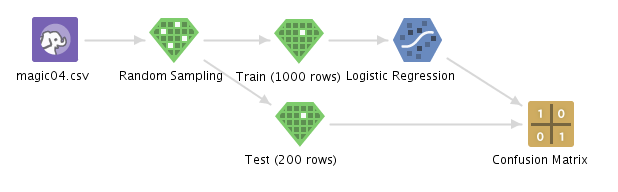

In [22]:
Image(filename='Images/Demo1.png')

### Let's run the workflow through a post.  We'll have this function return a process id, a unique identifier for this run.  We can use the id later to query or download flow results.

In [84]:
def run_workflow(wid):
    
    run_url = alpine_base_url + "/alpinedatalabs/api/v1/json/workflows/" + str(wid) + "/run" #+ "?saveResult=true"
    print run_url
    
    chorus_host = alpine_base_url.split("http://")[1]
    
    alpine_session.headers.update({"x-token": session_id})
    alpine_session.headers.update({"Host": chorus_host})
    alpine_session.headers.update({"Content-Type": "application/json"})
    run_response = alpine_session.post(run_url, timeout=30)
    
    print run_response.content
        
    process_id = run_response.json()['meta']['processId']
    return process_id
    
process_id = run_workflow(workflow_id)
print(process_id)

http://54.183.194.189:8080/alpinedatalabs/api/v1/json/workflows/2263/run
{"meta":{"workflowId":"2263","processId":"79d071e0-93de-47bc-b0bc-5316b53d55f4","user":"111","state":"STARTED"},"message":"workflow started","results":""}

79d071e0-93de-47bc-b0bc-5316b53d55f4


### Workflows can take a while to complete.  We can poll the status of the workflow using the `/query` endpoint.  You can run this cell several times to see how the status changes as the workflow progresses.  A `response.text` string of 'Workflow not started or already stopped' indicates that the workflow has completed.

In [85]:
query_url = alpine_base_url + "/alpinedatalabs/api/v1/json/processes/" + str(process_id) + "/query"
alpine_session.headers.update({"x-token": session_id})
alpine_session.headers.update({"Content-Type": "application/json"})
query_response = alpine_session.get(query_url, timeout=60)
print(query_response.text)

{"meta":{"workflowId":"2263","processId":"79d071e0-93de-47bc-b0bc-5316b53d55f4","user":"111","state":"NODE_STARTED"},"nodeInfo":{"nodeId":"1434394448655","nodeName":"Random Sampling"},"message":" started running...","results":""}



### We could continue to run the previous cell over and over to test if the workflow is complete, but it's better to write a function that periodically tests it for us until it is finished.

### Run the next cell while the workflow is still in progress.

In [86]:
def get_workflow_status(pid, sid):
    
    query_url = alpine_base_url + "/alpinedatalabs/api/v1/json/processes/" + str(pid) + "/query"
    alpine_session.headers.update({"x-token": sid})
    alpine_session.headers.update({"Content-Type": "application/json"})
    
    status_response = alpine_session.get(query_url, timeout=60)
    
    in_progress_states = ["IN_PROGRESS", "NODE_STARTED", "STARTED", "NODE_FINISHED"]
    if status_response.status_code == 200:
        try:
            if status_response.json()['meta']['state'] in in_progress_states:
                return "WORKING"
        except ValueError:
            if status_response.text == 'Workflow not started or already stopped.\n' or resp.text == "invalid processId or workflow already stopped.\n":
                return "FINISHED"
            else:
                return "FAILED"
    else:
        raise Exception("Workflow failed with status {0}: {1}".format(status_response.status_code, status_response.reason))
        

def wait_for_workflow_to_finish(sid, wid, pid, wait_time=5):
    
    time_elapsed = 0
    start_time = time.time()
    
    while get_workflow_status(pid, sid) == "WORKING":
            
            time_elapsed = time.time() - start_time
            print("\rWorkflow in progress for ~{0:.1f} seconds.".format(time_elapsed)),
            time.sleep(wait_time)
                
    print("\rWorkflow finished in ~{0:.1f} seconds.".format(time_elapsed))
    

wait_for_workflow_to_finish(session_id, workflow_id, process_id)

Workflow finished in ~65.4 seconds.


### Now we can download the result.  `workflow_result` contains all the information that appears in the bottom window of the Alpine workflow editor, along with some logs and metadata.   To access that information we can convert it from a JSON string to a nested dict/list python object.  This can potentially be quite large.  Generally, we won't want to print it to screen, but go ahead and do it once if you are curious.


In [89]:
def get_workflow_results(wid, pid):
    result_url = alpine_base_url + "/alpinedatalabs/api/v1/json/workflows/" + str(workflow_id) + "/results/" + str(process_id)
    response = alpine_session.get(result_url)
    return response
    
workflow_result = get_workflow_results(workflow_id, process_id)
result = json.loads(workflow_result.json())
#pprint(result)

###  The output  from each operator is stored in the list `result['outputs']`.  For instance, the name of the ith operator can be found at `result['outputs'][i]['out_title']`.

In [90]:
operator_list = result['outputs']
print("Number of operators in workflow = {}".format(len(operator_list)))
print("Name of the 3rd operator is '{}'".format(operator_list[3]['out_title']))

Number of operators in workflow = 6
Name of the 3rd operator is 'Train (1000 rows)'


### We are interested in knowing the prediction accuracy of our trained logistic regression model on the test set.  In the workflow, this is calculated in the *Confusion Matrix* operator.  We can iterate over this list to find the operator that has the matching name.

In [91]:
def find_operator(name, oper_list):
    for oper in oper_list:
        if oper['out_title'] == name:
            return oper
    return []

matching_name = 'Confusion Matrix'
output_operator = find_operator(matching_name, operator_list)
pprint(output_operator)

{u'isGenerateReport': True,
 u'out_id': 1476467866353.8694,
 u'out_title': u'Confusion Matrix',
 u'visualData': [{u'isGenerateReport': True,
                  u'out_id': 1476467866350.943,
                  u'out_title': u'Logistic Regression: Data',
                  u'visualData': {u'columnTypes': [u'cate',
                                                   u'cate',
                                                   u'cate',
                                                   u'cate'],
                                  u'columns': [u' ',
                                               u'Predicted (0)',
                                               u'Predicted (1)',
                                               u'Class Recall'],
                                  u'fixedNumberOfColumns': 0,
                                  u'items': [{u' ': u'Observed (0)',
                                              u'Class Recall': u'0.4559',
                                              u'Predict

### Each operator has a different data output format, but for a *Confusion Matrix*, we can find the prediction accuracy on the test set like this.

In [92]:
acc = output_operator['visualData'][1]['visualData']['heatMapTable']['accuracy']
print("Accuracy = {0:.1f}%".format(acc*100))

Accuracy = 78.7%
